In [89]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import coresets
from sklearn.datasets import make_blobs 
np.random.seed(0)

In [90]:
X1, _ = make_blobs(n_samples=300, n_features=2, centers=2, cluster_std=0.5)
X2, _ = make_blobs(n_samples=10, n_features=2, centers=1, cluster_std=0.5)
X = np.vstack((X1, X2 + 10))

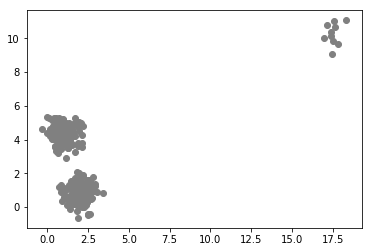

In [91]:
plt.scatter(X[:, 0], X[:, 1], c='gray')

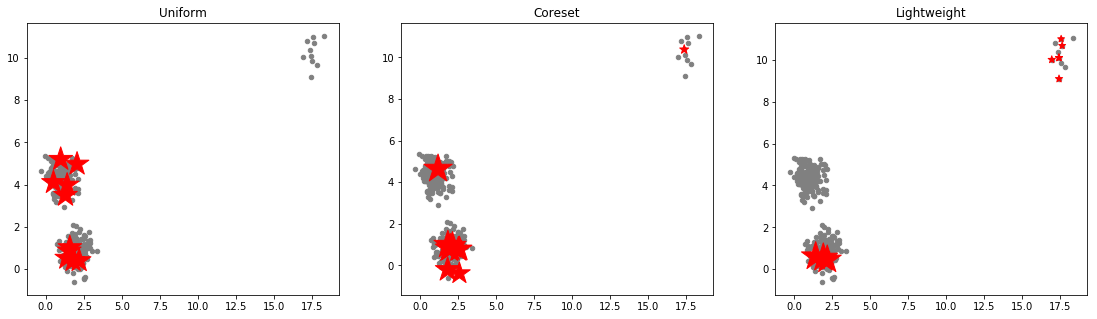

In [95]:
coreset_size = 10
fig = plt.figure(figsize=(19, 5))
for i, (method, name) in enumerate([(coresets.KMeansUniformGenerator(X), "Uniform"),
                    (coresets.KMeansCoresetGenerator(X, n_clusters=3), "Coreset"),
                    (coresets.KMeansLightweightCoresetGenerator(X), "Lightweight")]):
    C, w = method.generate_coreset(coreset_size)
    ax = plt.subplot(1, 3, i + 1)
    ax.set_title(name)
    plt.scatter(X[:, 0], X[:, 1], c='gray', s=20)
    plt.scatter(C[:, 0], C[:, 1], c='red', marker="*", s=w*20)


# Wine experiments

In [101]:
from sklearn.datasets import load_wine
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X, _ = load_wine(return_X_y=True)
std_pca = make_pipeline(StandardScaler(), PCA(n_components=5))
X = std_pca.fit_transform(X)